# In the extended data, we include several figures with data split by song/DC 

In the main text, we perform our analyses making no distinction between call types (Song or DC).

Here, we run these analyses, but treating song and DC trials from each subject separately. Where we used paired t-tests previously, we now use linear mixed effects modeling and testing nested models with call type included/excluded as a fixed effect.

In [1]:
import os
import sys

In [2]:
from pathlib import Path

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
from matplotlib.gridspec import GridSpec
from statsmodels.stats.oneway import anova_oneway
from statsmodels.stats.multicomp import pairwise_tukeyhsd

from zf_data import Tsvk, load_trials
from zf_data.plotting import (
    border,
    color_by_reward,
    draw_k_axis,
    draw_logor_axes_markers,
    draw_probability_axes_markers,
    figure_cm,
    fig_grid,
    smoothhist,
    shaded_line,
)
from zf_data.stats import false_discovery, likelihood_ratio_test, two_to_one_tail
from zf_data.utils import parse_p, setup_mpl_params
from zf_data.constants import *

In [3]:
setup_mpl_params()

In [4]:
%load_ext autoreload
%autoreload 2

## Set up utilities

In [5]:
SAVE_FIGS = True  #@param {type: "boolean"}
FIGDIR = "figures/svg_originals"  #@param {type: "string"}
FIGDIR = Path(FIGDIR)

FIGDIR.mkdir(parents=True, exist_ok=True)

def savedir(rel_path):
    """Return the save path relative to FIGDIR"""
    return str(FIGDIR / rel_path)

# JNeurosci column sizes in cm
COL1 = 8.5  #@param {type: "number"}
COL1_5 = 11.6  #@param {type: "number"}
COL2 = 17.6  #@param {type: "number"}


In [6]:
def get_or_create_Tsvk(df: pd.DataFrame, k_max: int = None) -> Tsvk:
    """Create a Tsvk instance from a dataframe, or return a cached one for that data
    
    If the df.index and k_max match a previously computed Tsvk, return that one. Otherwise,
    instantiate a new Tsvk() instance.
    
    Tsvk instances are hashed by a tuple of the dataframe index and k_max requested.
    """
    key = (tuple(df.index), k_max)
    if key not in get_or_create_Tsvk.cache:
        get_or_create_Tsvk.cache[key] = Tsvk(df, k_max=k_max)
    return get_or_create_Tsvk.cache[key]
get_or_create_Tsvk.cache = {}


def test_get_or_create_Tsvk(df: pd.DataFrame):
    backup = get_or_create_Tsvk.cache.copy()
    get_or_create_Tsvk.cache = {}
    t1 = get_or_create_Tsvk(df[(df.LesionStage == "prelesion") & (df.VocalizerSet == "S1")], k_max=11)
    t2 = get_or_create_Tsvk(df[(df.LesionStage == "prelesion") & (df.VocalizerSet == "S1")], k_max=11)
    t3 = get_or_create_Tsvk(df[(df.LesionStage == "prelesion") & (df.VocalizerSet == "S1")], k_max=12)
    t4 = get_or_create_Tsvk(df[(df.LesionStage == "postlesion") & (df.VocalizerSet == "S2")], k_max=12)
    
    assert t1 is t2
    assert t1 is not t3
    assert t2 is not t3
    assert t1 is not t4
    assert t2 is not t4
    print("Tests pass")
    
    get_or_create_Tsvk.cache = backup
    


## Load data

In [7]:
df = load_trials()

## Extended Data Figure 3-1 (Songs and DCs)

Here we reproduce Fig 3A and 3B with songs and distance calls separately.

We can quantify the first bin in which things are significant for S1 before lesion.

We can compare baseline interruption rates for songs and DCs (doesn't mirror any particular analysis in main text)


In [8]:
def figure3a(call_type: str, ax: plt.Axes = None):
    """Plots learning curves for inital learning of S1 stimuli before lesion"""
    if ax is None:
        ax = plt.gca()

    # Get prelesion data (initial learning)
    tsvk = get_or_create_Tsvk(df[
        (df.LesionStage == "prelesion")
        & (df.StimulusCallType == call_type)
        & (df.VocalizerSet == "S1")
    ], k_max=11)

    # Get probability of interruption (avg over subjects) for each k
    p_nore = tsvk.nore.p_by_k()
    p_re = tsvk.re.p_by_k()

    shaded_line(
        p_re["k"], 
        p_re["P_int"], 
        2 * p_re["SE"],
        line_kwargs={"color": color_by_reward.get("Rewarded"), "label": "Re"},
        ax=ax
    )
    
    shaded_line(
        p_nore["k"], 
        p_nore["P_int"], 
        2 * p_nore["SE"],
        line_kwargs={"color": color_by_reward.get("Nonrewarded"), "label": "NoRe"},
        ax=ax
    )

def figure3a_odds(call_type: str, ax: plt.Axes = None):
    """Plots learning curves for inital learning of S1 stimuli before lesion"""
    if ax is None:
        ax = plt.gca()

    # Get prelesion data (initial learning)
    tsvk = get_or_create_Tsvk(df[
        (df.LesionStage == "prelesion")
        & (df.StimulusCallType == call_type)
        & (df.VocalizerSet == "S1")
    ], k_max=11)

    # Get odds-ratio (avg over subjects) for each k
    logOR = tsvk.logOR()

    shaded_line(
        logOR["k"], 
        logOR["logOR"], 
        2 * logOR["SE"],
        ax=ax
    )
    
    pvalues = logOR["pvalue"]
    first_bin = np.where(false_discovery(pvalues, alpha=0.05))[0][0]

    print(f"Figure 3-1A ({call_type}, Bottom)")
    print("------------------")
    print(f"  During the initial exposures to S1")
    print(f"  the smallest bin k where log2OR > 0 could be detected: k={first_bin}")
    print(f"    k=0; logOR = {logOR['logOR'][0]:.2f}, t({logOR['dof'][0]}) = {logOR['tstat'][0]:.2f}, {parse_p(pvalues[0])}")

    # Draw overlay lines showing the logOR of each individual group
    
    for treatment in ["NCM", "HVC", "CTRL"]:
        tsvk_treatment = get_or_create_Tsvk(df[
            (df.LesionStage == "prelesion")
            & (df.VocalizerSet == "S1")
            & (df.StimulusCallType == call_type)
            & (df.SubjectTreatment == treatment)
        ], k_max=11)
        
        logOR = tsvk_treatment.logOR()

        ax.plot(
            logOR["k"], 
            logOR["logOR"], 
            **{
                "linestyle": LINEMAP[treatment],
                "color": COLORMAP[treatment],
                "zorder": -1,
                "linewidth": 1,
            },
        )

def figure3b(call_type: str, ax: plt.Axes = None):
    """Plots learning curves for final stage of ladder before lesion"""
    if ax is None:
        ax = plt.gca()

    # Get prelesion data (late in learning) 
    tsvk = get_or_create_Tsvk(df[
        (df.LesionStage == "prelesion")
        & (df.VocalizerSet == "S1")
        & (df.StimulusCallType == call_type)
        & df.LadderStage.isin(["SovsSo_8v8_d2", "DCvsDC_6v6_d2"])
    ], k_max=11)

    # Get probability of interruption as a function of k
    p_nore = tsvk.nore.p_by_k()
    p_re = tsvk.re.p_by_k()

    shaded_line(
        p_re["k"], 
        p_re["P_int"], 
        2 * p_re["SE"],
        line_kwargs={"color": color_by_reward.get("Rewarded"), "label": "Re"},
        ax=ax
    )
    shaded_line(
        p_nore["k"], 
        p_nore["P_int"], 
        2 * p_nore["SE"],
        line_kwargs={"color": color_by_reward.get("Nonrewarded"), "label": "NoRe"},
        ax=ax
    )

    
def figure3b_odds(call_type: str, ax: plt.Axes = None):
    """Plots learning curves for final stage of ladder before lesion"""
    if ax is None:
        ax = plt.gca()
        
    # Get prelesion data (late in learning) 
    tsvk = get_or_create_Tsvk(df[
        (df.LesionStage == "prelesion")
        & (df.VocalizerSet == "S1")
        & (df.StimulusCallType == call_type)
        & df.LadderStage.isin(["SovsSo_8v8_d2", "DCvsDC_6v6_d2"])
    ], k_max=11)

    # Get odds-ratio (avg over subjects) for each k
    logOR = tsvk.logOR()

    shaded_line(
        logOR["k"], 
        logOR["logOR"], 
        2 * logOR["SE"],
        ax=ax
    )
    
    pvalues = logOR["pvalue"]
    first_bin = np.where(false_discovery(pvalues, alpha=0.05))[0][0]

    print(f"Figure S3-1B ({call_type}, Bottom)")
    print("------------------")
    print(f"  On days 6v6-d2/8v8-d2 for pre-lesion learning of S1")
    print(f"  the smallest bin k where log2OR > 0 could be detected: k={first_bin}")
    print(f"    k=0; logOR = {logOR['logOR'][0]:.2f}, t({logOR['dof'][0]}) = {logOR['tstat'][0]:.2f}, {parse_p(pvalues[0])}")

    # Draw overlay lines showing the logOR of each individual group

    for treatment in ["NCM", "HVC", "CTRL"]:
        tsvk_treatment = get_or_create_Tsvk(df[
            (df.LesionStage == "prelesion")
            & (df.VocalizerSet == "S1")
            & (df.SubjectTreatment == treatment)
            & (df.StimulusCallType == call_type)
            & df.LadderStage.isin(["SovsSo_8v8_d2", "DCvsDC_6v6_d2"])
        ], k_max=11)

        logOR = tsvk_treatment.logOR()

        ax.plot(
            logOR["k"], 
            logOR["logOR"], 
            **{
                "linestyle": LINEMAP[treatment],
                "color": COLORMAP[treatment],
                "zorder": -1,
                "linewidth": 1,
            },
        )

def figure4a(call_type: str, treatment: str, ax: plt.Axes = None):
    """Plots learning curves for initial stage of ladder AFTER lesion"""
    if ax is None:
        ax = plt.gca()

    # Get post-lesion data in initial sessions after lesion
    tsvk = get_or_create_Tsvk(df[
        (df.LesionStage == "postlesion")
        & (df.VocalizerSet == "S1")
        & (df.StimulusCallType == call_type)
        & (df.SubjectTreatment == treatment)
    ], k_max=11)

    # Compute probability of interruption as a funciton of k
    p_nore = tsvk.nore.p_by_k()
    p_re = tsvk.re.p_by_k()

    shaded_line(
        p_re["k"], 
        p_re["P_int"], 
        2 * p_re["SE"],
        line_kwargs={"color": color_by_reward.get("Rewarded"), "label": "Re"},
        ax=ax
    )
    shaded_line(
        p_nore["k"], 
        p_nore["P_int"], 
        2 * p_nore["SE"],
        line_kwargs={"color": color_by_reward.get("Nonrewarded"), "label": "NoRe"},
        ax=ax
    )

    
def figure4b(call_type: str, ax: plt.Axes = None):
    """Plots odds ratios of lesioned birds during initial stage of ladder AFTER lesion"""
    if ax is None:
        ax = plt.gca()

    print("Figure S4-1B")
    print("---------")

    # Overlay odds ratio curves for each treatment type

    for treatment in ["NCM", "HVC", "CTRL", ("HVC", "CTRL")]:
        if isinstance(treatment, str):
            treatment_filter = df.SubjectTreatment == treatment
        elif isinstance(treatment, tuple):
            treatment_filter = np.zeros_like(df.SubjectTreatment).astype(bool)
            for t in treatment:
                treatment_filter |= df.SubjectTreatment == t
                
        tsvk_treatment = get_or_create_Tsvk(df[
            (df.LesionStage == "postlesion")
            & (df.VocalizerSet == "S1")
            & (df.StimulusCallType == call_type)
            & treatment_filter
        ], k_max=11)

        logOR = tsvk_treatment.logOR()
        
        if isinstance(treatment, str):
            shaded_line(
                logOR["k"], 
                logOR["logOR"], 
                2 * logOR["SE"],
                ax=ax,
                line_kwargs={
                    "color": COLORMAP[treatment],
                    "linestyle": LINEMAP[treatment],
                },
            )
        else:
            print(f"Computing combined treatments, {treatment}")
            print(f"==========================================")
        
        pvalues = logOR["pvalue"]
        first_bin = np.where(false_discovery(pvalues, alpha=0.05))[0][0]
        
        print(f" The {treatment} group after lesion, being re-exposed to S1")
        print("--------")
        print(f"  the smallest bin k where log2OR > 0 could be detected: k={first_bin}")        

        print(f"    k=0; {treatment}: logOR = {logOR['logOR'][0]:.2f}, t({logOR['dof'][0]}) = {logOR['tstat'][0]:.2f}, {parse_p(pvalues[0])}")
        print(f"    k=1; {treatment}: logOR = {logOR['logOR'][1]:.2f}, t({logOR['dof'][1]}) = {logOR['tstat'][1]:.2f}, {parse_p(pvalues[1])}")
        print()

        
def figure4c_data(call_type: str, ax: plt.Axes = None, group_hvc_and_ctrl=False):
    """Generates a table of post-lesion logOR
    """
    post_data = []
    
    k_array = tuple(np.arange(K_MAX_INITIAL + 1))  # The values of k to compute over

    for treatment in ["NCM", "HVC", "CTRL"]:
        tsvk_post = get_or_create_Tsvk(df[
            (df.LesionStage == "postlesion")
            & (df.VocalizerSet == "S1")
            & (df.StimulusCallType == call_type)
            & (df.SubjectTreatment == treatment)
        ], k_max=11)
        
        logor_data = tsvk_post.logOR_by_subjects(k=k_array)
        if group_hvc_and_ctrl:
            logor_data["Treatment"] = "HVC/CTRL" if treatment in ("HVC", "CTRL") else treatment
        else:
            logor_data["Treatment"] = treatment
        logor_data["CallType"] = call_type
        
        post_data.append(logor_data)
        
    return pd.concat(post_data)


Figure Dimensions 17.60cm x 6.00cm


Figure 3-1A (SO, Bottom)
------------------
  During the initial exposures to S1
  the smallest bin k where log2OR > 0 could be detected: k=5
    k=0; logOR = -1.80, t(20) = -2.83, p = 0.995

Figure S3-1B (SO, Bottom)
------------------
  On days 6v6-d2/8v8-d2 for pre-lesion learning of S1
  the smallest bin k where log2OR > 0 could be detected: k=0
    k=0; logOR = 3.61, t(20) = 5.87, p < 0.001 (***)

Figure S4-1B
---------
 The NCM group after lesion, being re-exposed to S1
--------
  the smallest bin k where log2OR > 0 could be detected: k=3
    k=0; NCM: logOR = -0.23, t(9) = -0.31, p = 0.617
    k=1; NCM: logOR = 1.07, t(9) = 1.28, p = 0.116

 The HVC group after lesion, being re-exposed to S1
--------
  the smallest bin k where log2OR > 0 could be detected: k=0
    k=0; HVC: logOR = 2.22, t(6) = 3.18, p = 0.010 (**)
    k=1; HVC: logOR = 3.33, t(6) = 5.93, p = 0.001 (***)

 The CTRL group after lesion, being re-exposed to S1
--------
  the sma

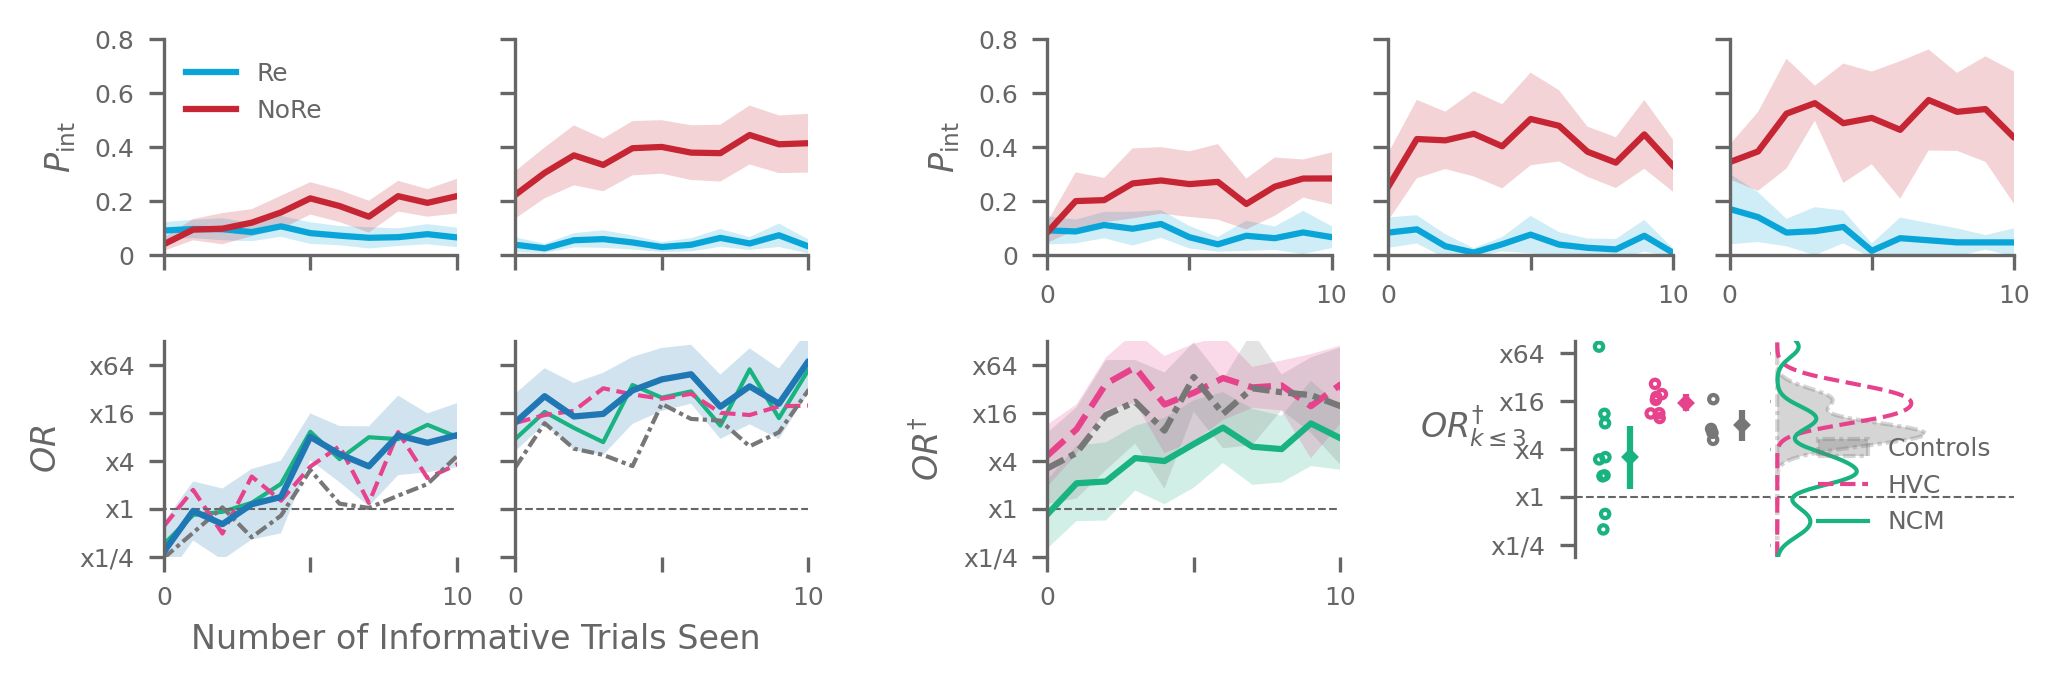

In [9]:
CALL_TYPE = "SO"

fig = figure_cm(COL2, 6, dpi=300)
print()

hspace = 0.4
wspace = 0.2
gridspec_kw = {"hspace": hspace, "wspace": wspace}

subfigs = fig.subfigures(1, 2, width_ratios=[2, 3])

##########
# 3A, 3B #
##########
axes = subfigs[0].subplots(2, 2, sharex=True, gridspec_kw=gridspec_kw)

figure3a(CALL_TYPE, axes[0, 0])
figure3b(CALL_TYPE, axes[0, 1])
print()
figure3a_odds(CALL_TYPE, axes[1, 0])
print()
figure3b_odds(CALL_TYPE, axes[1, 1])
print()

for ax in axes[0]:
    draw_probability_axes_markers(ax=ax)
for ax in axes[1]:
    draw_logor_axes_markers(smallest=-2, biggest=7, convert_log=False, ax=ax)
    ax.set_ylim(-2, 7)
    border(ax, 1, 0, 0, 0)
for ax in axes[0]:
    ax.tick_params(labelbottom=False)
for ax in axes[:, 1]:
    ax.tick_params(labelleft=False)

for ax in axes.flatten():
    draw_k_axis(k_max=11, ax=ax)
    
axes[0, 0].legend(fontsize=6, loc="upper left", frameon=False)

axes[0, 0].set_ylabel(r"$P_{\mathrm{int}}$", fontsize=8)
axes[1, 0].set_ylabel(r"$OR$", fontsize=8)

subfigs[0].supxlabel("Number of Informative Trials Seen", fontsize=8)
subfigs[0].subplots_adjust(bottom=0.15)

######
# 4A #
######

subfigs_right = subfigs[1].subfigures(1, 1)

# I'm creating a dummy row so that the top row of plots are aligned with the 3A,3B
axes, delete_axes = subfigs_right.subplots(2, 3, sharey=True, gridspec_kw=gridspec_kw)
for ax in delete_axes:
    ax.remove()

figure4a(CALL_TYPE, "NCM", ax=axes[0])
figure4a(CALL_TYPE, "HVC", ax=axes[1])
figure4a(CALL_TYPE, "CTRL", ax=axes[2])

for ax in axes:
    draw_probability_axes_markers(ax=ax)

for ax in axes.flatten():
    draw_k_axis(k_max=11, ax=ax)

axes[0].set_ylabel(r"$P_{\mathrm{int}}$", fontsize=8)

# 4B: Lesioned subject odds ratios
subfigs_bottom = subfigs[1].subfigures(1, 1)
delete_axes, axes = subfigs_bottom.subplots(2, 2, gridspec_kw=dict(width_ratios=[1, 2], **gridspec_kw))
for ax in delete_axes:
    ax.remove()

# Split the remaining space 
last_ax_position = axes[1].get_position()
bounds = last_ax_position.bounds
w = bounds[2]
scatter_ax_bounds = [
    bounds[0] + 1.5 * w/6, 
    bounds[1], 
    2 * w / 6, 
    bounds[3]
]
last_ax_position.x0 = (last_ax_position.x0 + 3.5 * w / 6)
axes[1].set_position(last_ax_position)
ax_scatter = subfigs_bottom.add_axes(scatter_ax_bounds)

# axes[1].sharey(ax_scatter)

######
# 4B #
######
figure4b(CALL_TYPE, ax=axes[0])

draw_logor_axes_markers(smallest=-2, biggest=7, convert_log=False, ax=axes[0])
axes[0].set_ylim(-2, 7)
draw_k_axis(k_max=11, ax=axes[0])
axes[0].set_ylabel(r"$OR^{\dagger}$", fontsize=8)
border(axes[0], 1, 0, 0, 0)


######
# 4C #
######
post = figure4c_data(CALL_TYPE)

post_ncm = post[post["Treatment"] == "NCM"]
post_hvc = post[post["Treatment"] == "HVC"]
post_ctrl = post[post["Treatment"] == "CTRL"]

ax = axes[1]
smoothhist(np.array(post_ctrl["logOR"]), range=(-2.5, 6.5), bins=20, ax=ax, color=CTRL_COLOR, label="Controls", orientation="horizontal", fill=True, alpha=0.3, linewidth=1, linestyle=CTRL_LINESTYLE)
smoothhist(np.array(post_hvc["logOR"]), range=(-2.5, 6.5), bins=20, ax=ax, color=HVC_COLOR, label="HVC", orientation="horizontal", linewidth=1, linestyle=HVC_LINESTYLE)
smoothhist(np.array(post_ncm["logOR"]), range=(-2.5, 6.5), bins=20, ax=ax, color=NCM_COLOR, label="NCM", orientation="horizontal", linewidth=1, linestyle=NCM_LINESTYLE)

ax.legend(fontsize=6, loc="lower right", frameon=False)

xlim = ax.get_xlim()
ax.set_xlim(xlim[0], xlim[0] + 1.5 * (xlim[1] - xlim[0]))
ax.set_xticks([], [])
border(ax, 0, 0, 0, 0)
ax.tick_params(labelleft=False, labelbottom=False)
ax.hlines(0, *plt.xlim(), color=AX_COLOR, linestyle="--", linewidth=0.5, zorder=-1)

# draw_logor_axes_markers(smallest=-2, biggest=7, convert_log=False, ax=ax)
# ax.set_ylim(-2, 2)

ax_scatter.scatter(np.random.normal(0, 0.1, len(post_ncm)), post_ncm["logOR"], s=4, linewidth=1, edgecolor=NCM_COLOR, facecolor="none")
ax_scatter.scatter(np.random.normal(2, 0.1, len(post_hvc)), post_hvc["logOR"], s=4, linewidth=1, edgecolor=HVC_COLOR, facecolor="none")
ax_scatter.scatter(np.random.normal(4, 0.1, len(post_ctrl)), post_ctrl["logOR"], s=4, linewidth=1, edgecolor=CTRL_COLOR, facecolor="none")

ax_scatter.errorbar(
    1,
    np.mean(post_ncm["logOR"]), 
    yerr=2 * np.std(post_ncm["logOR"]) / np.sqrt(len(post_ncm)),
    markersize=2,
    marker="D",
    color=NCM_COLOR,
)
ax_scatter.errorbar(
    3,
    np.mean(post_hvc["logOR"]), 
    yerr=2 * np.std(post_hvc["logOR"]) / np.sqrt(len(post_hvc)),
    markersize=2,
    marker="D",
    color=HVC_COLOR,
)
ax_scatter.errorbar(
    5,
    np.mean(post_ctrl["logOR"]), 
    yerr=2 * np.std(post_ctrl["logOR"]) / np.sqrt(len(post_ctrl)),
    markersize=2,
    marker="D",
    color=CTRL_COLOR,
)

ax_scatter.set_xlim(-1, 6)
ax_scatter.hlines(0, *plt.xlim(), color=AX_COLOR, linestyle="--", linewidth=0.5, zorder=-1)
border(ax_scatter, 1, 0, 0, 0)
ax_scatter.set_xticks([])
ax_scatter.set_ylabel(r"$OR^{\dagger}_{k \leq 3}$", fontsize=8, rotation=0)

for ax_ in [ax, ax_scatter]:
    ax_.set_ylim(-2.5, 6.5)
    ax_.set_yticks([ -2, 0, 2, 4, 6], ["x1/4", "x1", "x4", "x16", "x64"], fontsize=6)


if SAVE_FIGS:
    fig.savefig(savedir("figS3-1.svg"), format="svg", bbox_inches="tight")


Figure Dimensions 17.60cm x 6.00cm


Figure 3-1A (DC, Bottom)
------------------
  During the initial exposures to S1
  the smallest bin k where log2OR > 0 could be detected: k=4
    k=0; logOR = -1.95, t(20) = -3.29, p = 0.998

Figure S3-1B (DC, Bottom)
------------------
  On days 6v6-d2/8v8-d2 for pre-lesion learning of S1
  the smallest bin k where log2OR > 0 could be detected: k=0
    k=0; logOR = 1.70, t(20) = 2.12, p = 0.024 (*)

Figure S4-1B
---------
 The NCM group after lesion, being re-exposed to S1
--------
  the smallest bin k where log2OR > 0 could be detected: k=3
    k=0; NCM: logOR = 0.41, t(9) = 0.39, p = 0.351
    k=1; NCM: logOR = 0.90, t(9) = 1.00, p = 0.172

 The HVC group after lesion, being re-exposed to S1
--------
  the smallest bin k where log2OR > 0 could be detected: k=0
    k=0; HVC: logOR = 1.19, t(6) = 2.39, p = 0.027 (*)
    k=1; HVC: logOR = 3.66, t(6) = 4.41, p = 0.002 (**)

 The CTRL group after lesion, being re-exposed to S1
--------
  the smallest 

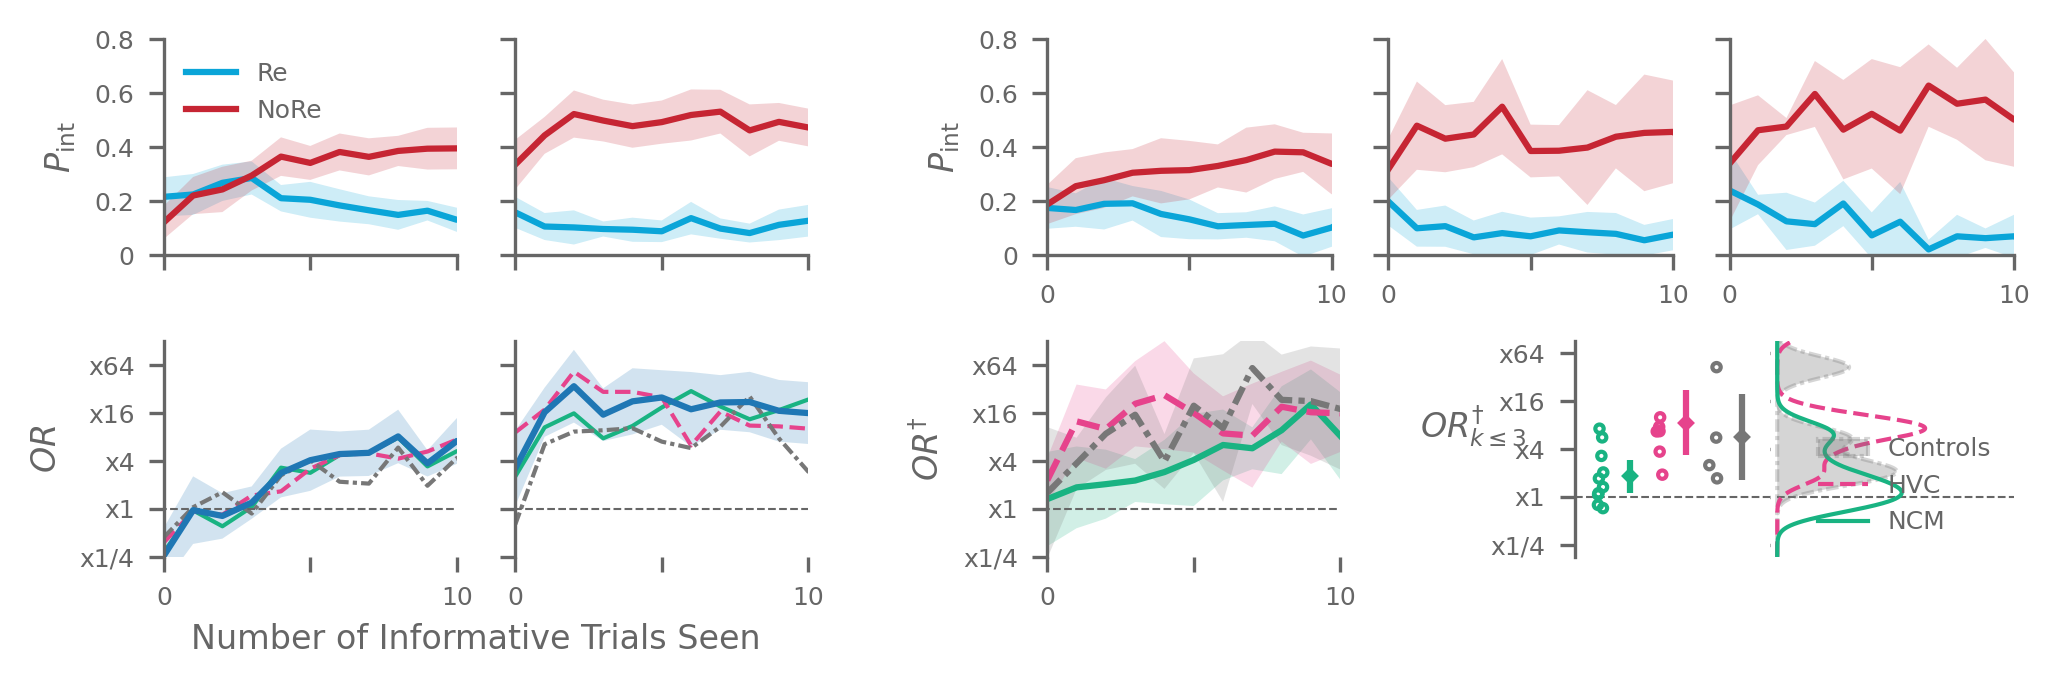

In [10]:
CALL_TYPE = "DC"

fig = figure_cm(COL2, 6, dpi=300)
print()

hspace = 0.4
wspace = 0.2
gridspec_kw = {"hspace": hspace, "wspace": wspace}

subfigs = fig.subfigures(1, 2, width_ratios=[2, 3])

##########
# 3A, 3B #
##########
axes = subfigs[0].subplots(2, 2, sharex=True, gridspec_kw=gridspec_kw)

figure3a(CALL_TYPE, axes[0, 0])
figure3b(CALL_TYPE, axes[0, 1])
print()
figure3a_odds(CALL_TYPE, axes[1, 0])
print()
figure3b_odds(CALL_TYPE, axes[1, 1])
print()

for ax in axes[0]:
    draw_probability_axes_markers(ax=ax)
for ax in axes[1]:
    draw_logor_axes_markers(smallest=-2, biggest=7, convert_log=False, ax=ax)
    ax.set_ylim(-2, 7)
    border(ax, 1, 0, 0, 0)
for ax in axes[0]:
    ax.tick_params(labelbottom=False)
for ax in axes[:, 1]:
    ax.tick_params(labelleft=False)

for ax in axes.flatten():
    draw_k_axis(k_max=11, ax=ax)
    
axes[0, 0].legend(fontsize=6, loc="upper left", frameon=False)

axes[0, 0].set_ylabel(r"$P_{\mathrm{int}}$", fontsize=8)
axes[1, 0].set_ylabel(r"$OR$", fontsize=8)

subfigs[0].supxlabel("Number of Informative Trials Seen", fontsize=8)
subfigs[0].subplots_adjust(bottom=0.15)

######
# 4A #
######

subfigs_right = subfigs[1].subfigures(1, 1)

# I'm creating a dummy row so that the top row of plots are aligned with the 3A,3B
axes, delete_axes = subfigs_right.subplots(2, 3, sharey=True, gridspec_kw=gridspec_kw)
for ax in delete_axes:
    ax.remove()

figure4a(CALL_TYPE, "NCM", ax=axes[0])
figure4a(CALL_TYPE, "HVC", ax=axes[1])
figure4a(CALL_TYPE, "CTRL", ax=axes[2])

for ax in axes:
    draw_probability_axes_markers(ax=ax)

for ax in axes.flatten():
    draw_k_axis(k_max=11, ax=ax)

axes[0].set_ylabel(r"$P_{\mathrm{int}}$", fontsize=8)

# 4B: Lesioned subject odds ratios
subfigs_bottom = subfigs[1].subfigures(1, 1)
delete_axes, axes = subfigs_bottom.subplots(2, 2, gridspec_kw=dict(width_ratios=[1, 2], **gridspec_kw))
for ax in delete_axes:
    ax.remove()

# Split the remaining space 
last_ax_position = axes[1].get_position()
bounds = last_ax_position.bounds
w = bounds[2]
scatter_ax_bounds = [
    bounds[0] + 1.5 * w/6, 
    bounds[1], 
    2 * w / 6, 
    bounds[3]
]
last_ax_position.x0 = (last_ax_position.x0 + 3.5 * w / 6)
axes[1].set_position(last_ax_position)
ax_scatter = subfigs_bottom.add_axes(scatter_ax_bounds)

# axes[1].sharey(ax_scatter)

######
# 4B #
######
figure4b(CALL_TYPE, ax=axes[0])

draw_logor_axes_markers(smallest=-2, biggest=7, convert_log=False, ax=axes[0])
axes[0].set_ylim(-2, 7)
draw_k_axis(k_max=11, ax=axes[0])
axes[0].set_ylabel(r"$OR^{\dagger}$", fontsize=8)
border(axes[0], 1, 0, 0, 0)


######
# 4C #
######
post = figure4c_data(CALL_TYPE)

post_ncm = post[post["Treatment"] == "NCM"]
post_hvc = post[post["Treatment"] == "HVC"]
post_ctrl = post[post["Treatment"] == "CTRL"]

ax = axes[1]
smoothhist(np.array(post_ctrl["logOR"]), range=(-2.5, 6.5), bins=20, ax=ax, color=CTRL_COLOR, label="Controls", orientation="horizontal", fill=True, alpha=0.3, linewidth=1, linestyle=CTRL_LINESTYLE)
smoothhist(np.array(post_hvc["logOR"]), range=(-2.5, 6.5), bins=20, ax=ax, color=HVC_COLOR, label="HVC", orientation="horizontal", linewidth=1, linestyle=HVC_LINESTYLE)
smoothhist(np.array(post_ncm["logOR"]), range=(-2.5, 6.5), bins=20, ax=ax, color=NCM_COLOR, label="NCM", orientation="horizontal", linewidth=1, linestyle=NCM_LINESTYLE)

ax.legend(fontsize=6, loc="lower right", frameon=False)

xlim = ax.get_xlim()
ax.set_xlim(xlim[0], xlim[0] + 1.5 * (xlim[1] - xlim[0]))
ax.set_xticks([], [])
border(ax, 0, 0, 0, 0)
ax.tick_params(labelleft=False, labelbottom=False)
ax.hlines(0, *plt.xlim(), color=AX_COLOR, linestyle="--", linewidth=0.5, zorder=-1)

# draw_logor_axes_markers(smallest=-2, biggest=7, convert_log=False, ax=ax)
# ax.set_ylim(-2, 2)

ax_scatter.scatter(np.random.normal(0, 0.1, len(post_ncm)), post_ncm["logOR"], s=4, linewidth=1, edgecolor=NCM_COLOR, facecolor="none")
ax_scatter.scatter(np.random.normal(2, 0.1, len(post_hvc)), post_hvc["logOR"], s=4, linewidth=1, edgecolor=HVC_COLOR, facecolor="none")
ax_scatter.scatter(np.random.normal(4, 0.1, len(post_ctrl)), post_ctrl["logOR"], s=4, linewidth=1, edgecolor=CTRL_COLOR, facecolor="none")

ax_scatter.errorbar(
    1,
    np.mean(post_ncm["logOR"]), 
    yerr=2 * np.std(post_ncm["logOR"]) / np.sqrt(len(post_ncm)),
    markersize=2,
    marker="D",
    color=NCM_COLOR,
)
ax_scatter.errorbar(
    3,
    np.mean(post_hvc["logOR"]), 
    yerr=2 * np.std(post_hvc["logOR"]) / np.sqrt(len(post_hvc)),
    markersize=2,
    marker="D",
    color=HVC_COLOR,
)
ax_scatter.errorbar(
    5,
    np.mean(post_ctrl["logOR"]), 
    yerr=2 * np.std(post_ctrl["logOR"]) / np.sqrt(len(post_ctrl)),
    markersize=2,
    marker="D",
    color=CTRL_COLOR,
)

ax_scatter.set_xlim(-1, 6)
ax_scatter.hlines(0, *plt.xlim(), color=AX_COLOR, linestyle="--", linewidth=0.5, zorder=-1)
border(ax_scatter, 1, 0, 0, 0)
ax_scatter.set_xticks([])
ax_scatter.set_ylabel(r"$OR^{\dagger}_{k \leq 3}$", fontsize=8, rotation=0)

for ax_ in [ax, ax_scatter]:
    ax_.set_ylim(-2.5, 6.5)
    ax_.set_yticks([ -2, 0, 2, 4, 6], ["x1/4", "x1", "x4", "x16", "x64"], fontsize=6)


if SAVE_FIGS:
    fig.savefig(savedir("figS3-2.svg"), format="svg", bbox_inches="tight")


# Interruption probabilities for Song and DC

Comparing them for completely novel stimuli (k=0 on first exposure)

And comparing interruption rates late in learning (6v6-d2/8v8-d2) 


In [11]:
tsvk = get_or_create_Tsvk(df[
    (df.LesionStage == "prelesion")
    & (df.StimulusCallType == "DC")
    & (df.VocalizerSet == "S1")
], k_max=11)
dc_interruptions_by_subject = tsvk.p_by_subjects(k=0)

tsvk = get_or_create_Tsvk(df[
    (df.LesionStage == "prelesion")
    & (df.StimulusCallType == "SO")
    & (df.VocalizerSet == "S1")
], k_max=11)
song_interruptions_by_subject = tsvk.p_by_subjects(k=0)

tstat, pvalue = scipy.stats.ttest_rel(dc_interruptions_by_subject["P_int"], song_interruptions_by_subject["P_int"], alternative="two-sided")
dof = len(dc_interruptions_by_subject) - 1
print("Seeing if birds initially (k=0) interrupt songs differently than distance calls (two-tailed)")
print(f"   t({dof}) = {tstat:.2f}, {parse_p(pvalue)}")
print(f"   p(song) - p(dc) = {np.mean(song_interruptions_by_subject['P_int'] - dc_interruptions_by_subject['P_int']):.2f}")

print(f"Subjects initially interrupted DCs with P_int = {np.mean(dc_interruptions_by_subject['P_int']):.2f}")
print(f"Subjects initially interrupted songs with P_int = {np.mean(song_interruptions_by_subject['P_int']):.2f}")


Seeing if birds initially (k=0) interrupt songs differently than distance calls (two-tailed)
   t(20) = 3.11, p = 0.006 (**)
   p(song) - p(dc) = -0.10
Subjects initially interrupted DCs with P_int = 0.17
Subjects initially interrupted songs with P_int = 0.07


In [12]:
tsvk = get_or_create_Tsvk(df[
    (df.LesionStage == "prelesion")
    & (df.StimulusCallType == "DC")
    & (df.VocalizerSet == "S1")
    & df.LadderStage.isin(["SovsSo_8v8_d2", "DCvsDC_6v6_d2"])
])
dc_logor_by_subjects = tsvk.fisher_exact_by_subjects()

print(f" DC Interrupt Re: p = {np.mean(tsvk.re.df['Interrupt']):.2f}")
print(f" DC Interrupt NoRe: p = {np.mean(tsvk.nore.df['Interrupt']):.2f}")

print()

tsvk = get_or_create_Tsvk(df[
    (df.LesionStage == "prelesion")
    & (df.StimulusCallType == "SO")
    & (df.VocalizerSet == "S1")
    & df.LadderStage.isin(["SovsSo_8v8_d2", "DCvsDC_6v6_d2"])
])
song_logor_by_subjects = tsvk.fisher_exact_by_subjects()

print(f" Song Interrupt Re: p = {np.mean(tsvk.re.df['Interrupt']):.2f}")
print(f" Song Interrupt NoRe: p = {np.mean(tsvk.nore.df['Interrupt']):.2f}")

print()

 DC Interrupt Re: p = 0.18
 DC Interrupt NoRe: p = 0.74

 Song Interrupt Re: p = 0.09
 Song Interrupt NoRe: p = 0.62



## 4C ($k \le 3$ comparisons) with call types

We previously tested the scores in k <= 3, and tested them against chance and across lesion groups. Using ANOVA, we found that NCM < HVC ~ CTRL.

We see if this still holds when split by call type.

In [13]:
post_dc_k3 = figure4c_data("DC")
post_song_k3 = figure4c_data("SO")
post_call_type_k3 = pd.concat([post_dc_k3, post_song_k3])

In [14]:
base_model = smf.mixedlm(
    "logOR ~ Treatment",
    groups=post_call_type_k3["Subject"],
    data=post_call_type_k3,
    re_formula="1",
).fit(reml=False)

alt_model = smf.mixedlm(
    "logOR ~ Treatment + CallType + Treatment:CallType",
    groups=post_call_type_k3["Subject"],
    data=post_call_type_k3,
    re_formula="1",
).fit(reml=False)

pvalue, x, dof = likelihood_ratio_test(base_model, alt_model)

print(f"Is a model that includes both")
print(f" CallType and Treatment:CallType interaction term")
print(f" a better fit than just a model using Treatment as a fixed effect?")
print(f"Chi2({dof}) = {x:.2f}, {parse_p(pvalue)}")

print()
if pvalue < 0.05:
    print(" YES")
else:
    print(" NO")

display(alt_model.summary())

Is a model that includes both
 CallType and Treatment:CallType interaction term
 a better fit than just a model using Treatment as a fixed effect?
Chi2(3) = 3.53, p = 0.317

 NO


<class 'statsmodels.iolib.summary2.Summary'>
"""
                  Mixed Linear Model Regression Results
==========================================================================
Model:                    MixedLM       Dependent Variable:       logOR   
No. Observations:         42            Method:                   ML      
No. Groups:               21            Scale:                    1.5700  
Min. group size:          2             Log-Likelihood:           -75.5296
Max. group size:          2             Converged:                Yes     
Mean group size:          2.0                                             
--------------------------------------------------------------------------
                                Coef.  Std.Err.   z    P>|z| [0.025 0.975]
--------------------------------------------------------------------------
Intercept                        2.499    0.748  3.341 0.001  1.033  3.965
Treatment[T.HVC]                 0.600    0.938  0.640 0.522 -1.238  2.437
Treatment[T.NCM]                -1.629    0.885 -1.841 0.066 -3.363  0.106
CallType[T.SO]                   0.496    0.886  0.559 0.576 -1.241  2.232
Treatment[T.HVC]:CallType[T.SO]  0.336    1.111  0.302 0.762 -1.841  2.513
Treatment[T.NCM]:CallType[T.SO]  0.296    1.048  0.282 0.778 -1.759  2.350
Group Var                        0.668    0.506                           
==========================================================================

"""

### Figure 4C upper significance tests (one-sample t-tests)
Testing for task performance above chance level with $k \le 3$ for S1 post-lesion?

In [15]:
# Effect sizes post-lesion
print("Magnitude of postlesion k<=3 for song")
for treatment in ["NCM", "HVC", "CTRL"]:
    treatment_data = post_song_k3[post_song_k3["Treatment"] == treatment]
    logor = np.mean(treatment_data["logOR"])
    ttest_result = scipy.stats.ttest_1samp(treatment_data["logOR"], 0)
    print(f" {treatment}: logOR = {logor:.2f}, t({len(treatment_data) - 1}) = {ttest_result.statistic:.2f}, {parse_p(ttest_result.pvalue)}")   
    
print()

print("Magnitude of postlesion k<=3 for DC")
for treatment in ["NCM", "HVC", "CTRL"]:
    treatment_data = post_dc_k3[post_dc_k3["Treatment"] == treatment]
    logor = np.mean(treatment_data["logOR"])
    ttest_result = scipy.stats.ttest_1samp(treatment_data["logOR"], 0)
    print(f" {treatment}: logOR = {logor:.2f}, t({len(treatment_data) - 1}) = {ttest_result.statistic:.2f}, {parse_p(ttest_result.pvalue)}")

Magnitude of postlesion k<=3 for song
 NCM: logOR = 1.66, t(9) = 2.40, p = 0.040 (*)
 HVC: logOR = 3.93, t(6) = 20.01, p < 0.001 (***)
 CTRL: logOR = 2.99, t(3) = 8.00, p = 0.004 (**)

Magnitude of postlesion k<=3 for DC
 NCM: logOR = 0.87, t(9) = 2.40, p = 0.040 (*)
 HVC: logOR = 3.10, t(6) = 4.20, p = 0.006 (**)
 CTRL: logOR = 2.50, t(3) = 2.41, p = 0.095


### Figure 4C lower significance tests (unpaired t-tests)

Next we run the comparison (lower significance markers in 4C) between NCM and HVC and controls group. We also run the ANOVA for differences between all three groups, but we don't show this in the figure.

In [16]:
post_dc_k3_grouped = figure4c_data("DC", group_hvc_and_ctrl=True)
post_song_k3_grouped = figure4c_data("SO", group_hvc_and_ctrl=True)

print("Unpaired, two-sided t-test result (Song)")
print("------------")
ttest_result = scipy.stats.ttest_ind(
    post_song_k3_grouped[post_song_k3_grouped["Treatment"] == "HVC/CTRL"]["logOR"],
    post_song_k3_grouped[post_song_k3_grouped["Treatment"] == "NCM"]["logOR"],
)
print(f"  t({len(post_song_k3_grouped) - 2}) = {ttest_result.statistic:.2f}, {parse_p(ttest_result.pvalue)}")

print()

print("Unpaired, two-sided t-test result (DC)")
print("------------")

ttest_result = scipy.stats.ttest_ind(
    post_dc_k3_grouped[post_dc_k3_grouped["Treatment"] == "HVC/CTRL"]["logOR"],
    post_dc_k3_grouped[post_dc_k3_grouped["Treatment"] == "NCM"]["logOR"],
)
print(f"  t({len(post_song_k3_grouped) - 2}) = {ttest_result.statistic:.2f}, {parse_p(ttest_result.pvalue)}")


Unpaired, two-sided t-test result (Song)
------------
  t(19) = 2.76, p = 0.013 (*)

Unpaired, two-sided t-test result (DC)
------------
  t(19) = 2.88, p = 0.010 (**)


In [17]:
post_dc_k3 = figure4c_data("DC", group_hvc_and_ctrl=False)
post_song_k3 = figure4c_data("SO", group_hvc_and_ctrl=False)

# ANOVA and Tukeys post-hoc test for differences in postlesion logOR for k <= 3
anova_result = anova_oneway(
    post_song_k3["logOR"],
    groups=post_song_k3["Treatment"],
    use_var="equal",
)
print()
print("ANOVA result (Song)")
print("------------")
print(" A significant difference between the groups was detected")
print(f"  F({anova_result.df_num}, {anova_result.df_denom}) = {anova_result.statistic:.2f}, {parse_p(anova_result.pvalue)}")
print()
tukey = pairwise_tukeyhsd(
    endog=post_song_k3["logOR"],
    groups=post_song_k3["Treatment"],
    alpha=0.05)
print(tukey)
print()
   
# ANOVA and Tukeys post-hoc test for differences in postlesion logOR for k <= 3
anova_result = anova_oneway(
    post_dc_k3["logOR"],
    groups=post_dc_k3["Treatment"],
    use_var="equal",
)
print()
print("ANOVA result (DC)")
print("------------")
print(" A significant difference between the groups was detected")
print(f"  F({anova_result.df_num}, {anova_result.df_denom}) = {anova_result.statistic:.2f}, {parse_p(anova_result.pvalue)}")
print()
tukey = pairwise_tukeyhsd(
    endog=post_dc_k3["logOR"],
    groups=post_dc_k3["Treatment"],
    alpha=0.05)
print(tukey)
print()


ANOVA result (Song)
------------
 A significant difference between the groups was detected
  F(2.0, 18.0) = 4.21, p = 0.032 (*)

Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
  CTRL    HVC   0.9356 0.6293 -1.6338   3.505  False
  CTRL    NCM  -1.3333 0.3603 -3.7585   1.092  False
   HVC    NCM  -2.2689 0.0264  -4.289 -0.2487   True
----------------------------------------------------


ANOVA result (DC)
------------
 A significant difference between the groups was detected
  F(2.0, 18.0) = 4.18, p = 0.032 (*)

Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
  CTRL    HVC   0.5999 0.8277 -1.9998  3.1995  False
  CTRL    NCM  -1.6288 0.2345 -4.0826  0.8249  False
   HVC    NCM  -2.2287 0.0314 -4.2726 -0.1848   True
----------------------------------------------------

## Learning curve mixed effects modeling including call types.

In [18]:
def load_treatments(treatments=("NCM", "HVC", "CTRL"), group_hvc_and_ctrl=False):
    """Loads the postlesion data in immediate sessions after lesion for one of the treatment groups"""
    logors = []
    for treatment in treatments:
        for call_type in ["SO", "DC"]:
            tsvk = get_or_create_Tsvk(df[
                (df.LesionStage == "postlesion")
                & (df.VocalizerSet == "S1")
                & (df.StimulusCallType == call_type)
                & (df.SubjectTreatment == treatment)
            ], k_max=11)

            for i in range(tsvk.k_max):
                logOR = tsvk.logOR_by_subjects(k=i)
                if group_hvc_and_ctrl:
                    logOR["Treatment"] = "HVC/CTRL" if treatment in ("HVC", "CTRL") else treatment
                else:
                    logOR["Treatment"] = treatment
                logOR["CallType"] = call_type
                logOR["k"] = i
                logors.append(logOR)

    learning_curve_logors = pd.concat(logors)
    return learning_curve_logors

In [19]:
learning_curve_logors = load_treatments(["NCM", "HVC", "CTRL"])

# First for Song

print("Figure S4-1B Stats (SONG + DC)")
print("------------------------------")

base_model = smf.mixedlm(
    "logOR ~ k + Treatment",
    groups=learning_curve_logors["Subject"],
    data=learning_curve_logors,
    re_formula="1",
).fit(reml=False)

alt_model = smf.mixedlm(
    "logOR ~ k + Treatment + CallType + CallType:Treatment",
    groups=learning_curve_logors["Subject"],
    data=learning_curve_logors,
    re_formula="1",
).fit(reml=False)

pvalue, x, dof = likelihood_ratio_test(base_model, alt_model)
print("    We are testing if a model of the learning curves that includes ")
print("    a call type and call type / lesion interaction is a better fit than without")
print("    for modeling logOR in the range k = 0...10")
print()

if pvalue < 0.05:
    print("The hypothesis that the two models are equally likely is rejected")
    print("The mixed effects model with call type as a parameter better explains the data")
else:
    print("The hypothesis that the two models are equally likely is not rejected")

print()
print(f"Chi2({dof}) = {x:.2f}, {parse_p(pvalue)}")
print()

print(alt_model.summary())
print(base_model.summary())

Figure S4-1B Stats (SONG + DC)
------------------------------
    We are testing if a model of the learning curves that includes 
    a call type and call type / lesion interaction is a better fit than without
    for modeling logOR in the range k = 0...10

The hypothesis that the two models are equally likely is rejected
The mixed effects model with call type as a parameter better explains the data

Chi2(3) = 9.99, p = 0.019 (*)

                  Mixed Linear Model Regression Results
Model:                  MixedLM       Dependent Variable:       logOR     
No. Observations:       462           Method:                   ML        
No. Groups:             21            Scale:                    4.5802    
Min. group size:        22            Log-Likelihood:           -1027.4404
Max. group size:        22            Converged:                Yes       
Mean group size:        22.0                                              
-----------------------------------------------------------

In [20]:
learning_curve_logors = load_treatments(["NCM", "HVC", "CTRL"])

# First for Song

print("Figure S4-1B Stats (SONG)")
print("---------------")
song_data = learning_curve_logors[learning_curve_logors["CallType"] == "SO"]

base_model = smf.mixedlm(
    "logOR ~ k",
    groups=song_data["Subject"],
    data=song_data,
    re_formula="1",
).fit(reml=False)

alt_model = smf.mixedlm(
    "logOR ~ k + Treatment ",
    groups=song_data["Subject"],
    data=song_data,
    re_formula="1",
).fit(reml=False)

pvalue, x, dof = likelihood_ratio_test(base_model, alt_model)
print("We are testing if a model of the learning curves that includes a lesion treatment (3 lines) is a better fit than one without (1 line)")
print()

if pvalue < 0.05:
    print("The hypothesis that the two models are equally likely is rejected")
    print("The mixed effects model with treatment as a parameter better explains the data")
else:
    print("The hypothesis that the two models are equally likely is not rejected")

print()
print(f"Chi2({dof}) = {x:.2f}, {parse_p(pvalue)}")
print()

# print(alt_model.summary())
# print(base_model.summary())

# Post hoc

print()
print("Post Hoc tests")
print("--------------")

for comparison in [("NCM", "HVC"), ("NCM", "CTRL"), ("HVC", "CTRL")]:
    learning_curve_logors = load_treatments(comparison)
    song_data = learning_curve_logors[learning_curve_logors["CallType"] == "SO"]

    base_model = smf.mixedlm(
        "logOR ~ k",
        groups=song_data["Subject"],
        data=song_data,
        re_formula="1",
    ).fit(reml=False)

    alt_model = smf.mixedlm(
        "logOR ~ Treatment + k",
        groups=song_data["Subject"],
        data=song_data,
        re_formula="1",
    ).fit(reml=False)

    pvalue, x, dof = likelihood_ratio_test(base_model, alt_model)

    print(f"Testing if intercept of post-lesion S1 learning curves for {comparison[0]} is significantly different from {comparison[1]}?")
    print(f" likelihood ratio test; Chi2({dof}) = {x:.2f}, {parse_p(pvalue)}")
    
    # Wald test
    z = alt_model.tvalues[f"Treatment[T.{comparison[0]}]"]
    p = alt_model.wald_test_terms(scalar=True).table.loc["Treatment", "pvalue"]
    print(f" Wald test ({comparison[1]} - {comparison[0]}); Z = {z:.2f}, {parse_p(p)}")
    print()


Figure S4-1B Stats (SONG)
---------------
We are testing if a model of the learning curves that includes a lesion treatment (3 lines) is a better fit than one without (1 line)

The hypothesis that the two models are equally likely is rejected
The mixed effects model with treatment as a parameter better explains the data

Chi2(2) = 10.37, p = 0.006 (**)


Post Hoc tests
--------------
Testing if intercept of post-lesion S1 learning curves for NCM is significantly different from HVC?
 likelihood ratio test; Chi2(1) = 8.33, p = 0.004 (**)
 Wald test (HVC - NCM); Z = -3.28, p = 0.001 (**)

Testing if intercept of post-lesion S1 learning curves for NCM is significantly different from CTRL?
 likelihood ratio test; Chi2(1) = 3.49, p = 0.062
 Wald test (CTRL - NCM); Z = -1.99, p = 0.047 (*)

Testing if intercept of post-lesion S1 learning curves for HVC is significantly different from CTRL?
 likelihood ratio test; Chi2(1) = 0.92, p = 0.338
 Wald test (CTRL - HVC); Z = 0.98, p = 0.328



In [21]:
learning_curve_logors = load_treatments(["NCM", "HVC", "CTRL"])

# Now for DC

print("Figure S4-1B Stats (DC)")
print("---------------")
dc_data = learning_curve_logors[learning_curve_logors["CallType"] == "DC"]

base_model = smf.mixedlm(
    "logOR ~ k",
    groups=dc_data["Subject"],
    data=dc_data,
    re_formula="1",
).fit(reml=False)

alt_model = smf.mixedlm(
    "logOR ~ k + Treatment ",
    groups=dc_data["Subject"],
    data=dc_data,
    re_formula="1",
).fit(reml=False)

pvalue, x, dof = likelihood_ratio_test(base_model, alt_model)
print("We are testing if a model of the learning curves that includes a lesion treatment (3 lines) is a better fit than one without (1 line)")
print()

if pvalue < 0.05:
    print("The hypothesis that the two models are equally likely is rejected")
    print("The mixed effects model with treatment as a parameter better explains the data")
else:
    print("The hypothesis that the two models are equally likely is not rejected")

print()
print(f"Chi2({dof}) = {x:.2f}, {parse_p(pvalue)}")
print()

# print(alt_model.summary())
# print(base_model.summary())

# Post hoc

print()
print("Post Hoc tests")
print("--------------")

for comparison in [("NCM", "HVC"), ("NCM", "CTRL"), ("HVC", "CTRL")]:
    learning_curve_logors = load_treatments(comparison)
    dc_data = learning_curve_logors[learning_curve_logors["CallType"] == "DC"]

    base_model = smf.mixedlm(
        "logOR ~ k",
        groups=dc_data["Subject"],
        data=dc_data,
        re_formula="1",
    ).fit(reml=False)

    alt_model = smf.mixedlm(
        "logOR ~ Treatment + k",
        groups=dc_data["Subject"],
        data=dc_data,
        re_formula="1",
    ).fit(reml=False)

    pvalue, x, dof = likelihood_ratio_test(base_model, alt_model)
    
    print(f"Testing if intercept of post-lesion S1 learning curves for {comparison[0]} is significantly different from {comparison[1]}?")
    print(f" likelihood ratio test; Chi2({dof}) = {x:.2f}, {parse_p(pvalue)}")
    
    # Wald test
    z = alt_model.tvalues[f"Treatment[T.{comparison[0]}]"]
    p = alt_model.wald_test_terms(scalar=True).table.loc["Treatment", "pvalue"]
    print(f" Wald test ({comparison[1]} - {comparison[0]}); Z = {z:.2f}, {parse_p(p)}")
    print()


Figure S4-1B Stats (DC)
---------------
We are testing if a model of the learning curves that includes a lesion treatment (3 lines) is a better fit than one without (1 line)

The hypothesis that the two models are equally likely is not rejected

Chi2(2) = 5.98, p = 0.050


Post Hoc tests
--------------
Testing if intercept of post-lesion S1 learning curves for NCM is significantly different from HVC?
 likelihood ratio test; Chi2(1) = 5.24, p = 0.022 (*)
 Wald test (HVC - NCM); Z = -2.48, p = 0.013 (*)

Testing if intercept of post-lesion S1 learning curves for NCM is significantly different from CTRL?
 likelihood ratio test; Chi2(1) = 3.16, p = 0.076
 Wald test (CTRL - NCM); Z = -1.88, p = 0.060

Testing if intercept of post-lesion S1 learning curves for HVC is significantly different from CTRL?
 likelihood ratio test; Chi2(1) = 0.02, p = 0.883
 Wald test (CTRL - HVC); Z = 0.15, p = 0.883



## Extended Data Figure 5-1 (Songs and DCs)

Post-lesion learning curves

In [22]:
def figure5a(call_type: str, treatment: str, ax: plt.Axes = None):
    """Plots learning curves for learning a new vocalizer set S2"""
    if ax is None:
        ax = plt.gca()

    # Get data from the initial learning of S2
    tsvk = get_or_create_Tsvk(df[
        (df.LesionStage == "postlesion")
        & (df.VocalizerSet == "S2")
        & (df.StimulusCallType == call_type)
        & (df.SubjectTreatment == treatment)
    ], k_max=11)
    
    # Compute probability of interruption as a function of k
    p_nore = tsvk.nore.p_by_k()
    p_re = tsvk.re.p_by_k()

    shaded_line(
        p_re["k"], 
        p_re["P_int"], 
        2 * p_re["SE"],
        line_kwargs={
            "color": color_by_reward.get("Rewarded"), 
            "label": "Re",
        },
        ax=ax
    )
    shaded_line(
        p_nore["k"], 
        p_nore["P_int"], 
        2 * p_nore["SE"],
        line_kwargs={"color": color_by_reward.get("Nonrewarded"), "label": "NoRe"},
        ax=ax
    )

def figure5b(call_type: str, ax: plt.Axes = None):
    """Plots odds-ratios for learning a new vocalizer set S2"""
    if ax is None:
        ax = plt.gca()
        
    print(f"Figure S5-1B: {call_type}")
    print("-------------------------")

    for treatment in ["NCM", "HVC", "CTRL"]:
        tsvk_treatment = get_or_create_Tsvk(df[
            (df.LesionStage == "postlesion")
            & (df.VocalizerSet == "S2")
            & (df.StimulusCallType == call_type)
            & (df.SubjectTreatment == treatment)
        ], k_max=11)

        logOR = tsvk_treatment.logOR()

        shaded_line(
            logOR["k"], 
            logOR["logOR"], 
            2 * logOR["SE"],
            ax=ax,
            line_kwargs={
                "color": COLORMAP[treatment],
                "linestyle": LINEMAP[treatment]
            },
        )

        pvalues = logOR["pvalue"]
        first_bin = np.where(pvalues < 0.05)[0][0]
        print(f" The {treatment} group after lesion, being first exposed to S2")
        print(f"  the smallest bin k where log2OR > 0 could be detected: k={first_bin}")        

        print(f"    k=0; {treatment}: logOR = {logOR['logOR'][0]:.2f}, t({logOR['dof'][0]}) = {logOR['tstat'][0]:.2f}, {parse_p(pvalues[0])}")
        print(f"    k=1; {treatment}: logOR = {logOR['logOR'][1]:.2f}, t({logOR['dof'][1]}) = {logOR['tstat'][1]:.2f}, {parse_p(pvalues[1])}")
        print()
    print()

Figure Dimensions 10.60cm x 6.00cm
Figure S5-1B: SO
-------------------------
 The NCM group after lesion, being first exposed to S2
  the smallest bin k where log2OR > 0 could be detected: k=1
    k=0; NCM: logOR = -1.10, t(9) = -1.80, p = 0.947
    k=1; NCM: logOR = 1.58, t(9) = 2.45, p = 0.018 (*)

 The HVC group after lesion, being first exposed to S2
  the smallest bin k where log2OR > 0 could be detected: k=3
    k=0; HVC: logOR = 0.66, t(6) = 0.76, p = 0.239
    k=1; HVC: logOR = 0.86, t(6) = 1.01, p = 0.176

 The CTRL group after lesion, being first exposed to S2
  the smallest bin k where log2OR > 0 could be detected: k=1
    k=0; CTRL: logOR = -0.09, t(3) = -0.17, p = 0.562
    k=1; CTRL: logOR = 1.13, t(3) = 2.95, p = 0.030 (*)




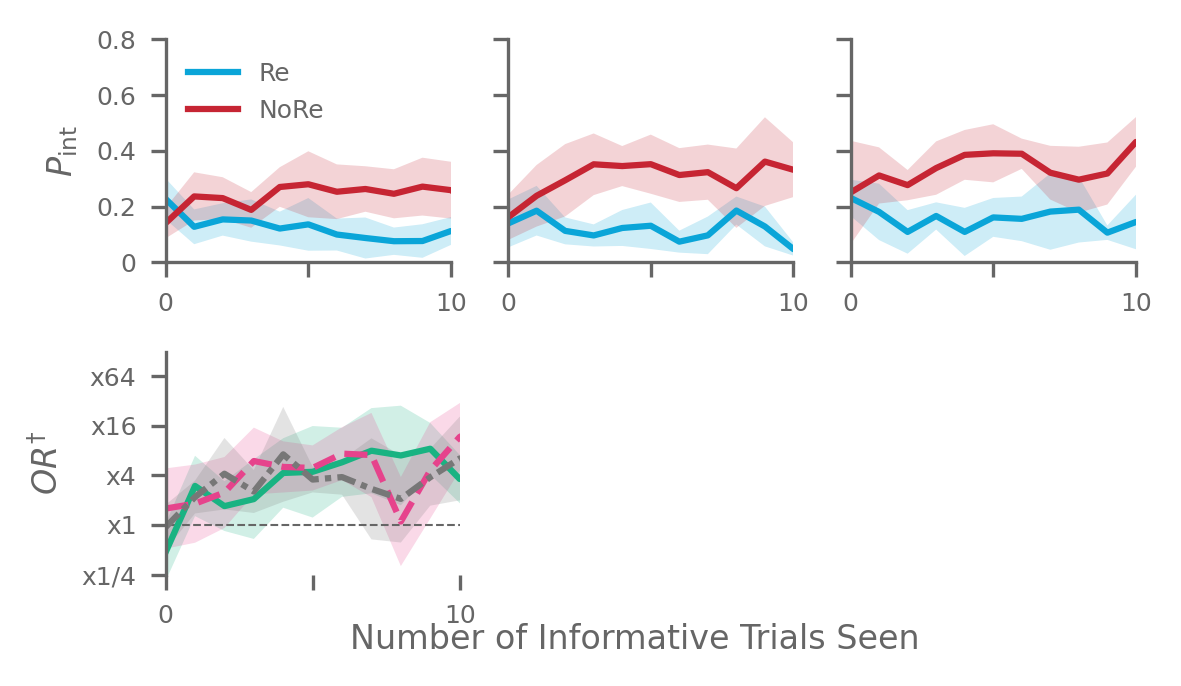

In [23]:
CALL_TYPE = "SO"

fig = figure_cm(COL1_5 - 1, 6, dpi=300)
hspace = 0.4
wspace = 0.2
gridspec_kw = {"hspace": hspace, "wspace": wspace}
subfigs = [None, fig]

# I'm creating a dummy row so that the top row of plots are aligned with the 3A,3B
axes, delete_axes = subfigs[1].subplots(2, 3, sharey=True, gridspec_kw=gridspec_kw)
for ax in delete_axes:
    ax.remove()

######
# 5A #
######
figure5a(CALL_TYPE, "NCM", ax=axes[0])
figure5a(CALL_TYPE, "HVC", ax=axes[1])
figure5a(CALL_TYPE, "CTRL", ax=axes[2])

for ax in axes:
    draw_probability_axes_markers(ax=ax)

for ax in axes.flatten():
    draw_k_axis(k_max=11, ax=ax)

axes[0].set_ylabel(r"$P_{\mathrm{int}}$", fontsize=8)
axes[0].legend(fontsize=6, loc="upper left", frameon=False)

# 3D: Lesioned subject odds ratios
subfigs_bottom = subfigs[1].subfigures(1, 1)
delete_axes, axes = subfigs_bottom.subplots(2, 2, gridspec_kw=dict(width_ratios=[1, 2], **gridspec_kw))
for ax in delete_axes:
    ax.remove()


######
# 5B #
######
figure5b(CALL_TYPE, ax=axes[0])

draw_logor_axes_markers(smallest=-2, biggest=7, convert_log=False, ax=axes[0])
axes[0].set_ylim(-2, 7)
draw_k_axis(k_max=11, ax=axes[0])
axes[0].set_ylabel(r"$OR^{\dagger}$", fontsize=8)
border(axes[0], 1, 0, 0, 0)

axes[1].remove()

fig.supxlabel("Number of Informative Trials Seen", fontsize=8)

if SAVE_FIGS:
    fig.savefig(savedir("figS5-1.svg"), format="svg", bbox_inches="tight")


Figure Dimensions 10.60cm x 6.00cm

Figure S5-1B: DC
-------------------------
 The NCM group after lesion, being first exposed to S2
  the smallest bin k where log2OR > 0 could be detected: k=4
    k=0; NCM: logOR = -1.21, t(9) = -2.26, p = 0.975
    k=1; NCM: logOR = -1.11, t(9) = -1.46, p = 0.911

 The HVC group after lesion, being first exposed to S2
  the smallest bin k where log2OR > 0 could be detected: k=3
    k=0; HVC: logOR = -1.59, t(6) = -3.25, p = 0.991
    k=1; HVC: logOR = 0.39, t(6) = 0.74, p = 0.244

 The CTRL group after lesion, being first exposed to S2
  the smallest bin k where log2OR > 0 could be detected: k=5
    k=0; CTRL: logOR = -1.45, t(3) = -21.31, p = 1.000
    k=1; CTRL: logOR = 0.47, t(3) = 0.51, p = 0.323




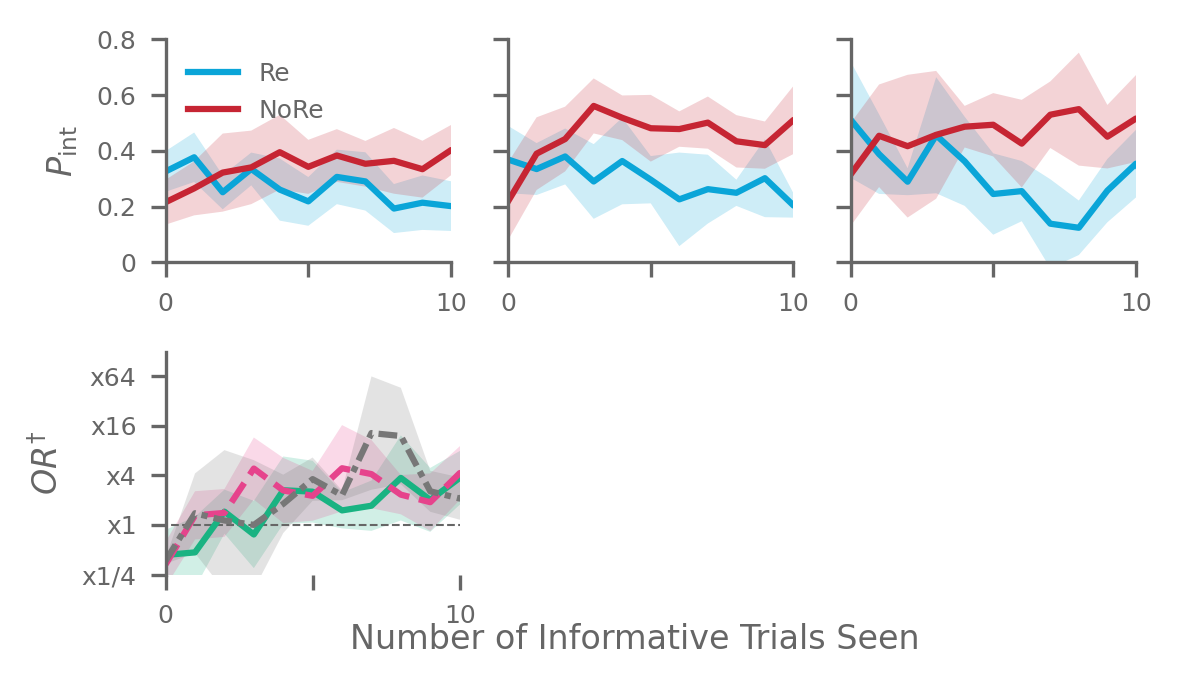

In [24]:
CALL_TYPE = "DC"

fig = figure_cm(COL1_5 - 1, 6, dpi=300)
print()

hspace = 0.4
wspace = 0.2
gridspec_kw = {"hspace": hspace, "wspace": wspace}
subfigs = [None, fig]

# I'm creating a dummy row so that the top row of plots are aligned with the 3A,3B
axes, delete_axes = subfigs[1].subplots(2, 3, sharey=True, gridspec_kw=gridspec_kw)
for ax in delete_axes:
    ax.remove()

######
# 5A #
######
figure5a(CALL_TYPE, "NCM", ax=axes[0])
figure5a(CALL_TYPE, "HVC", ax=axes[1])
figure5a(CALL_TYPE, "CTRL", ax=axes[2])

for ax in axes:
    draw_probability_axes_markers(ax=ax)

for ax in axes.flatten():
    draw_k_axis(k_max=11, ax=ax)

axes[0].set_ylabel(r"$P_{\mathrm{int}}$", fontsize=8)
axes[0].legend(fontsize=6, loc="upper left", frameon=False)

# 3D: Lesioned subject odds ratios
subfigs_bottom = subfigs[1].subfigures(1, 1)
delete_axes, axes = subfigs_bottom.subplots(2, 2, gridspec_kw=dict(width_ratios=[1, 2], **gridspec_kw))
for ax in delete_axes:
    ax.remove()


######
# 5B #
######
figure5b(CALL_TYPE, ax=axes[0])

draw_logor_axes_markers(smallest=-2, biggest=7, convert_log=False, ax=axes[0])
axes[0].set_ylim(-2, 7)
draw_k_axis(k_max=11, ax=axes[0])
axes[0].set_ylabel(r"$OR^{\dagger}$", fontsize=8)
border(axes[0], 1, 0, 0, 0)

axes[1].remove()

fig.supxlabel("Number of Informative Trials Seen", fontsize=8)

if SAVE_FIGS:
    fig.savefig(savedir("figS5-2.svg"), format="svg", bbox_inches="tight")


## Extended Data Figure 5-1B,D Analysis (Songs and DCs)

Re-running the learning curve mixed effects analysis of the main text, but split by call type.


In [25]:
def load_treatments_S2(treatments=("NCM", "HVC", "CTRL"), group_hvc_and_ctrl=False):
    """Loads the postlesion data in immediate sessions after lesion for one of the treatment groups"""
    logors = []
    for treatment in treatments:
        for call_type in ["SO", "DC"]:
            tsvk = get_or_create_Tsvk(df[
                (df.LesionStage == "postlesion")
                & (df.VocalizerSet == "S2")
                & (df.StimulusCallType == call_type)
                & (df.SubjectTreatment == treatment)
            ], k_max=11)

            for i in range(tsvk.k_max):
                logOR = tsvk.logOR_by_subjects(k=i)
                if group_hvc_and_ctrl:
                    logOR["Treatment"] = "HVC/CTRL" if treatment in ("HVC", "CTRL") else treatment
                else:
                    logOR["Treatment"] = treatment
                logOR["CallType"] = call_type
                logOR["k"] = i
                logors.append(logOR)

    learning_curve_logors = pd.concat(logors)
    return learning_curve_logors

In [26]:
learning_curve_logors = load_treatments_S2(["NCM", "HVC", "CTRL"])

# First for Song

print("Figure S5-1B Stats (SONG)")
print("---------------")
song_data = learning_curve_logors[learning_curve_logors["CallType"] == "SO"]

base_model = smf.mixedlm(
    "logOR ~ k",
    groups=song_data["Subject"],
    data=song_data,
    re_formula="1",
).fit(reml=False)

alt_model = smf.mixedlm(
    "logOR ~ k + Treatment ",
    groups=song_data["Subject"],
    data=song_data,
    re_formula="1",
).fit(reml=False)
pvalue, x, dof = likelihood_ratio_test(base_model, alt_model)
print("  We are testing if a model of the learning curves that includes a treatment is a better fit than without (for Song)")
print()
print(f"Base model converged: {base_model.converged}")
print(f"Alt model converged: {alt_model.converged}")
print("Because the base model did not converge, the p-value is a lower bound")
print()

if pvalue < 0.05:
    print("The hypothesis that the two models are equally likely is rejected")
    print("The mixed effects model with treatment as a parameter better explains the data")
else:
    print("The hypothesis that the two models are equally likely is not rejected")

print(f"Chi2({dof}) = {x:.2f}, {parse_p(pvalue)}")


Figure S5-1B Stats (SONG)
---------------


/Users/kevin/Projects/theunissenlab/zebra-finch-memory-lesions/env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/kevin/Projects/theunissenlab/zebra-finch-memory-lesions/env/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
/Users/kevin/Projects/theunissenlab/zebra-finch-memory-lesions/env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/kevin/Projects/theunissenlab/zebra-finch-memory-lesions/env/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with cg
  warnings.warn(
/

  We are testing if a model of the learning curves that includes a treatment is a better fit than without (for Song)

Base model converged: False
Alt model converged: True
Because the base model did not converge, the p-value is a lower bound

The hypothesis that the two models are equally likely is not rejected
Chi2(2) = 0.47, p = 0.789


In [27]:
# Next for DC

print("Figure S5-1B Stats (DC)")
print("---------------")
dc_data = learning_curve_logors[learning_curve_logors["CallType"] == "DC"]

base_model = smf.mixedlm(
    "logOR ~ k",
    groups=dc_data["Subject"],
    data=dc_data,
    re_formula="1",
).fit(reml=False)

alt_model = smf.mixedlm(
    "logOR ~ k + Treatment",
    groups=dc_data["Subject"],
    data=dc_data,
    re_formula="1",
).fit(reml=False)

pvalue, x, dof = likelihood_ratio_test(base_model, alt_model)
print("  We are testing if a model of the learning curves that includes a treatment is a better fit than without (for Song)")
print()
print(f"Base model converged: {base_model.converged}")
print(f"Alt model converged: {alt_model.converged}")
print()

if pvalue < 0.05:
    print("The hypothesis that the two models are equally likely is rejected")
    print("The mixed effects model with treatment as a parameter better explains the data")
else:
    print("The hypothesis that the two models are equally likely is not rejected")

print(f"Chi2({dof}) = {x:.2f}, {parse_p(pvalue)}")


Figure S5-1B Stats (DC)
---------------


/Users/kevin/Projects/theunissenlab/zebra-finch-memory-lesions/env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/kevin/Projects/theunissenlab/zebra-finch-memory-lesions/env/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(


  We are testing if a model of the learning curves that includes a treatment is a better fit than without (for Song)

Base model converged: True
Alt model converged: True

The hypothesis that the two models are equally likely is not rejected
Chi2(2) = 2.54, p = 0.281


## Overall task performance S2 (Song vs DC) most related to Extended Data Figure 6-1

In [28]:
def call_type_steady_state_analysis_S2():
    rows = []
    for treatment in ["NCM", "HVC", "CTRL"]:
        for call_type in ["SO", "DC"]:
            tsvk_S2_post = get_or_create_Tsvk(df[
                (df.LesionStage == "postlesion")
                & (df.VocalizerSet == "S2")
                & (df.SubjectTreatment == treatment)
                & (df.StimulusCallType == call_type)
                & df.LadderStage.isin(["DCvsDC_6v6_d2_S2", "SovsSo_8v8_d2_S2"])
            ])
            
            scores = tsvk_S2_post.fisher_exact_by_subjects(side="greater")

            for i in range(len(scores)):
                row = scores.iloc[i]
                rows.append({
                    "Subject": row["Subject"],
                    "logOR": row["logOR"],
                    "CallType": call_type,
                    "Treatment": treatment,
                })
    
    delta_data = pd.DataFrame(rows)
    
    base_model = smf.mixedlm(
        "logOR ~ Treatment",
        groups=delta_data["Subject"],
        data=delta_data,
        re_formula="1",
    ).fit(reml=False)

    alt_model = smf.mixedlm(
        "logOR ~ Treatment + CallType + Treatment:CallType",
        groups=delta_data["Subject"],
        data=delta_data,
        re_formula="1",
    ).fit(reml=False)

    pvalue, x, dof = likelihood_ratio_test(base_model, alt_model)

    print("We are testing on overall logOR for 6v6-d2/8v8-d2 data.")
    print(f"Is a model that includes CallType and Treatment:CallType interaction term a better fit than just a model using Treatment as a fixed effect?")
    print()
    print(f"  Chi2({dof}) = {x:.2f}, {parse_p(pvalue)}")
    print()
    if pvalue < 0.05:
        print(" YES")
    else:
        print(" NO")
    print()

    display(alt_model.summary())
call_type_steady_state_analysis_S2()

We are testing on overall logOR for 6v6-d2/8v8-d2 data.
Is a model that includes CallType and Treatment:CallType interaction term a better fit than just a model using Treatment as a fixed effect?

  Chi2(3) = 27.60, p < 0.001 (***)

 YES



<class 'statsmodels.iolib.summary2.Summary'>
"""
                  Mixed Linear Model Regression Results
==========================================================================
Model:                    MixedLM       Dependent Variable:       logOR   
No. Observations:         42            Method:                   ML      
No. Groups:               21            Scale:                    0.5707  
Min. group size:          2             Log-Likelihood:           -69.8824
Max. group size:          2             Converged:                Yes     
Mean group size:          2.0                                             
--------------------------------------------------------------------------
                                Coef.  Std.Err.   z    P>|z| [0.025 0.975]
--------------------------------------------------------------------------
Intercept                        2.635    0.809  3.256 0.001  1.049  4.221
Treatment[T.HVC]                 0.317    1.014  0.313 0.754 -1.671  2.306
Treatment[T.NCM]                -1.206    0.957 -1.259 0.208 -3.082  0.671
CallType[T.SO]                   1.213    0.534  2.270 0.023  0.166  2.260
Treatment[T.HVC]:CallType[T.SO]  0.964    0.670  1.440 0.150 -0.348  2.277
Treatment[T.NCM]:CallType[T.SO]  0.406    0.632  0.642 0.521 -0.833  1.644
Group Var                        2.048    1.348                           
==========================================================================

"""

## Extended Data Figure 6-1: Overall Task Performance on all sets

In [29]:
def figure_6(treatment: str, call_type: str = None, ax: plt.Axes = None):
    """Plot the overall odds ratios when the stimuli are well learned
    """
    if ax is None:
        ax = plt.gca()
        
    colormap = {
        "NCM": NCM_COLOR,
        "HVC": HVC_COLOR,
        "CTRL": CTRL_COLOR
    }
    
    if call_type is None:
        call_type_filter = np.ones_like(df.StimulusCallType).astype(bool)
    else:
        call_type_filter = df.StimulusCallType == call_type

    tsvk_S1_pre = get_or_create_Tsvk(df[
        (df.LesionStage == "prelesion")
        & (df.VocalizerSet == "S1")
        & (df.SubjectTreatment == treatment)
        & call_type_filter
        & df.LadderStage.isin(["DCvsDC_6v6_d2", "SovsSo_8v8_d2"])
    ])
    tsvk_S1_post = get_or_create_Tsvk(df[
        (df.LesionStage == "postlesion")
        & (df.VocalizerSet == "S1")
        & (df.SubjectTreatment == treatment)
        & call_type_filter
        & df.LadderStage.isin(["DCvsDC_6v6_d2", "SovsSo_8v8_d2"])
    ])
    tsvk_S2_post = get_or_create_Tsvk(df[
        (df.LesionStage == "postlesion")
        & (df.VocalizerSet == "S2")
        & (df.SubjectTreatment == treatment)
        & call_type_filter
        & df.LadderStage.isin(["DCvsDC_6v6_d2_S2", "SovsSo_8v8_d2_S2"])
    ])
        
    scores_1 = tsvk_S1_pre.fisher_exact_by_subjects(side="greater")
    scores_2 = tsvk_S1_post.fisher_exact_by_subjects(side="greater")
    scores_3 = tsvk_S2_post.fisher_exact_by_subjects(side="greater")
    
    mean_1 = np.mean(scores_1["logOR"])
    mean_2 = np.mean(scores_2["logOR"])
    mean_3 = np.mean(scores_3["logOR"])
    
    sem_1 = np.std(scores_1["logOR"]) / np.sqrt(len(scores_1))
    sem_2 = np.std(scores_2["logOR"]) / np.sqrt(len(scores_2))
    sem_3 = np.std(scores_2["logOR"]) / np.sqrt(len(scores_3))

    ax.plot([0, 1, 2], np.array([scores_1["logOR"], scores_2["logOR"], scores_3["logOR"]]), alpha=1, linewidth=1, color="0.8")

    ax.scatter(0 * np.ones(len(scores_1)), scores_1["logOR"], s=3, linewidth=1, alpha=1, facecolor="none", edgecolor="0.8")
    ax.scatter(1 * np.ones(len(scores_2)), scores_2["logOR"], s=3, linewidth=1, alpha=1, facecolor="none", edgecolor="0.8")
    ax.scatter(2 * np.ones(len(scores_3)), scores_3["logOR"], s=3, linewidth=1, alpha=1, facecolor="none", edgecolor="0.8")
    
    dof = len(scores_1) - 1

    print(" Paired t-test results to see if scores after lesion were worse than before lesion:")
    print("  S1' - S1")
    tstat, pvalue = scipy.stats.ttest_rel(scores_2["logOR"], scores_1["logOR"], alternative="less")
    print(f"   t({dof}) = {tstat:.2f}, {parse_p(pvalue)}")
    print(f"   diff = {np.mean(scores_2['logOR'] - scores_1['logOR']):.2f}")
    
    print("  S2' - S1")
    tstat, pvalue = scipy.stats.ttest_rel(scores_3["logOR"], scores_1["logOR"], alternative="less")
    print(f"   t({dof}) = {tstat:.2f}, {parse_p(pvalue)}")
    print(f"   diff = {np.mean(scores_3['logOR'] - scores_1['logOR']):.2f}")
    
    print()
    print(" One-sample t-test for logOR > 0:")
    dof = len(scores_2) - 1
    print("  S1'")
    tstat, pvalue = scipy.stats.ttest_1samp(scores_2["logOR"], 0, alternative="greater")
    print(f"   logOR = {np.mean(scores_2['logOR']):.2f}, t({dof}) = {tstat:.2f}, {parse_p(pvalue)}")
    print("  S2'")
    dof = len(scores_2) - 1
    tstat, pvalue = scipy.stats.ttest_1samp(scores_3["logOR"], 0, alternative="greater")
    print(f"   logOR = {np.mean(scores_3['logOR']):.2f}, t({dof}) = {tstat:.2f}, {parse_p(pvalue)}")

    print()
    ax.errorbar(
        [0.1, 1.1, 2.1], 
        [mean_1, mean_2, mean_3], 
        2 * np.array([sem_1, sem_2, sem_3]),
        linewidth=1.5, markersize=4, markerfacecolor="white", color=colormap[treatment], marker="d")
    

Figure Dimensions 10.60cm x 3.00cm
Song NCM
--------
 Paired t-test results to see if scores after lesion were worse than before lesion:
  S1' - S1
   t(9) = -2.18, p = 0.029 (*)
   diff = -1.76
  S2' - S1
   t(9) = -1.89, p = 0.045 (*)
   diff = -1.49

 One-sample t-test for logOR > 0:
  S1'
   logOR = 2.78, t(9) = 4.13, p = 0.001 (**)
  S2'
   logOR = 3.05, t(9) = 4.30, p = 0.001 (***)

DC NCM
--------
 Paired t-test results to see if scores after lesion were worse than before lesion:
  S1' - S1
   t(9) = -4.33, p = 0.001 (***)
   diff = -1.85
  S2' - S1
   t(9) = -4.66, p = 0.001 (***)
   diff = -2.32

 One-sample t-test for logOR > 0:
  S1'
   logOR = 1.90, t(9) = 5.04, p < 0.001 (***)
  S2'
   logOR = 1.43, t(9) = 3.38, p = 0.004 (**)

Song HVC
--------
 Paired t-test results to see if scores after lesion were worse than before lesion:
  S1' - S1
   t(6) = -1.38, p = 0.109
   diff = -0.59
  S2' - S1
   t(6) = 0.85, p = 0.786
   diff = 0.35

 One-sample t-test for logOR > 0:
  S1'


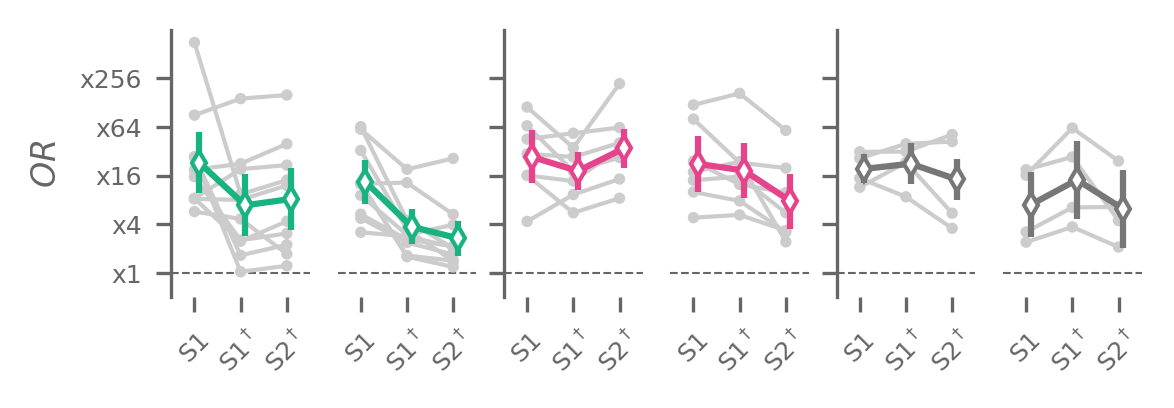

In [30]:
fig = figure_cm(COL1_5 - 1, 3, dpi=300)
axes = fig.subplots(1, 6)

print("Song NCM")
print("--------")
figure_6("NCM", "SO", ax=axes[0])

print("DC NCM")
print("--------")
figure_6("NCM", "DC", ax=axes[1])

print("Song HVC")
print("--------")
figure_6("HVC", "SO", ax=axes[2])

print("DC HVC")
print("--------")
figure_6("HVC", "DC", ax=axes[3])

print("Song CTRL")
print("--------")
figure_6("CTRL", "SO", ax=axes[4])

print("DC CTRL")
print("--------")
figure_6("CTRL", "DC", ax=axes[5])

for ax in axes:
    border(ax, 1)
    ax.set_xlim(-0.5, 2.5)

for ax in axes:
    draw_logor_axes_markers(smallest=-2, biggest=8, convert_log=False, ax=ax)
    ax.set_ylim(-1, 10)
    border(ax, 1)
    
for ax in axes[1::2]:
    border(ax)
    ax.set_yticks([])
    
for ax in axes[[2, 4]]:
    ax.tick_params(labelleft=False)

axes[0].set_ylabel("$OR$", fontsize=8)

for ax in axes:
    ax.set_xticks(
        [0, 1, 2],
        ["S1", "S1$^\dagger$", "S2$^\dagger$"],
        rotation=45,
        fontsize=6)

if SAVE_FIGS:
    fig.savefig(savedir("figS6-1.svg"), format="svg", bbox_inches="tight")


## Steady state analysis for S2 (Extended Data Figure 6-1)

In [31]:
def call_type_steady_state_analysis():
    rows = []
    for treatment in ["NCM", "HVC", "CTRL"]:
        for call_type in ["SO", "DC"]:
            tsvk_S1_pre = get_or_create_Tsvk(df[
                (df.LesionStage == "prelesion")
                & (df.VocalizerSet == "S1")
                & (df.SubjectTreatment == treatment)
                & (df.StimulusCallType == call_type)
                & df.LadderStage.isin(["DCvsDC_6v6_d2", "SovsSo_8v8_d2"])
            ])
            tsvk_S1_post = get_or_create_Tsvk(df[
                (df.LesionStage == "postlesion")
                & (df.VocalizerSet == "S1")
                & (df.SubjectTreatment == treatment)
                & (df.StimulusCallType == call_type)
                & df.LadderStage.isin(["DCvsDC_6v6_d2", "SovsSo_8v8_d2"])
            ])
            
            scores_1 = tsvk_S1_pre.fisher_exact_by_subjects(side="greater")
            scores_2 = tsvk_S1_post.fisher_exact_by_subjects(side="greater")

            for i in range(len(scores_1)):
                row = scores_1.iloc[i]
                row2 = scores_2.iloc[i]
                assert row["Subject"] == row2["Subject"]
                rows.append({
                    "Subject": row["Subject"],
                    "DeltaLogOR": row2["logOR"] - row["logOR"],
                    "CallType": call_type,
                    "Treatment": treatment,
                })
    
    delta_data = pd.DataFrame(rows)
    
    base_model = smf.mixedlm(
        "DeltaLogOR ~ Treatment",
        groups=delta_data["Subject"],
        data=delta_data,
        re_formula="1",
    ).fit(reml=False)

    alt_model = smf.mixedlm(
        "DeltaLogOR ~ Treatment + CallType + Treatment:CallType",
        groups=delta_data["Subject"],
        data=delta_data,
        re_formula="1",
    ).fit(reml=False)

    pvalue, x, dof = likelihood_ratio_test(base_model, alt_model)

    print("When we model the difference in logOR between pre- and post-lesion performance on S1 (on 6v6-d2/8v8-d2)")
    print(f"Is a model that includes CallType and Treatment:CallType interaction term a better fit than just a model using Treatment as a fixed effect?")
    print()
    print(f"Chi2({dof}) = {x:.2f}, {parse_p(pvalue)}")
    print()
    if pvalue < 0.05:
        print(" YES")
    else:
        print(" NO")

    # display(alt_model.summary())
    
call_type_steady_state_analysis()

When we model the difference in logOR between pre- and post-lesion performance on S1 (on 6v6-d2/8v8-d2)
Is a model that includes CallType and Treatment:CallType interaction term a better fit than just a model using Treatment as a fixed effect?

Chi2(3) = 1.70, p = 0.638

 NO
